# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import tensorflow
import keras
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from sklearn.model_selection import train_test_split

# Data loading

In [2]:
df = pd.read_csv("datasets/df_ptrc.csv")

<Axes: xlabel='Expression scaled', ylabel='Count'>

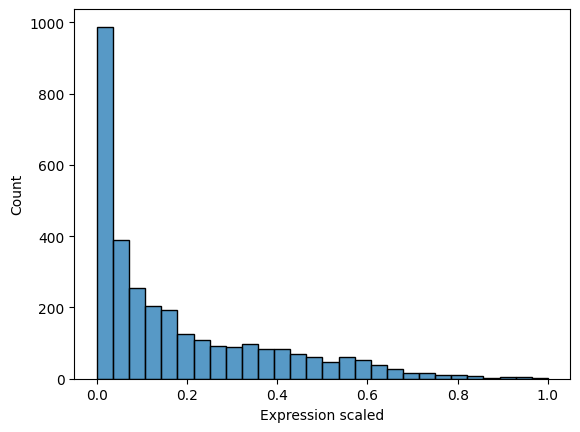

In [3]:
sns.histplot((df['Expression scaled']))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Promoter sequence  3140 non-null   object 
 1   Fluorescence       3140 non-null   float64
 2   Expression scaled  3140 non-null   float64
 3   Strength           3140 non-null   int64  
 4   Manual cluster 5   3140 non-null   int64  
 5   len                3140 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 147.3+ KB


In [5]:
df_train, df_test, y_train, y_test = train_test_split(df, df["Expression scaled"], test_size=0.2, random_state=42)

# ML models

In [6]:
df_train.head()

,Promoter sequence,Fluorescence,Expression scaled,Strength,Manual cluster 5,len
1292,TTGACAATTAATCATCCGGCTTGTATAATGTGTGGAATTGTGGGCG...,3145.419547,0.074407,0,0,74
2302,TTGACAATTAATCATCCGGCTTGTATAATGTGTGGAATTGTAAGCG...,11883.405540,0.287237,0,1,74
761,TTGACAATTAATCATCCGGCTCGTATAGTGTGTGGAATGGTGGGCG...,408.235746,0.007737,0,0,74
2194,TTGACAATTAATCATCCGGCTCGTATAGTGTGTGGAATTGTGGGCG...,3437.151732,0.081512,0,0,74
1241,TTGACAATTAATCGTCCGGCTCGTATAATGTGTGGAATTGTGGGCG...,6138.949616,0.147320,0,0,74


In [7]:
df_train_ML = df_train[['Promoter sequence', "Expression scaled"]]
df_test_ML = df_test[['Promoter sequence', "Expression scaled"]]

In [8]:
def get_sequence_in_columns(df):
    return pd.concat([df, df['Promoter sequence'].str.upper().apply(lambda x: pd.Series(list(x))).add_prefix('pos_')], axis=1)

In [9]:
df_train_ML = get_sequence_in_columns(df_train_ML)
df_test_ML = get_sequence_in_columns(df_test_ML)

In [10]:
X_ML_train = df_train_ML.drop(columns=['Promoter sequence', "Expression scaled"])
X_ML_test = df_test_ML.drop(columns=['Promoter sequence', "Expression scaled"])


In [11]:
y_ML_train = df_train["Expression scaled"]
y_ML_test = df_test["Expression scaled"]

In [12]:
encoder = OneHotEncoder(sparse_output=False)
encoded_X_ML_train = encoder.fit_transform(X_ML_train)
encoded_column_names = encoder.get_feature_names_out()
encoded_X_ML_test = encoder.transform(X_ML_test)

In [13]:
X_ML_train = pd.DataFrame(encoded_X_ML_train, columns=encoded_column_names)
X_ML_test = pd.DataFrame(encoded_X_ML_test, columns=encoded_column_names)

In [14]:
def run_model(model, X_train, y_train, X_test, y_test):
    L=[]
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    r2_train = r2_score(y_train,y_hat_train)
    r2_test = r2_score(y_test,y_hat_test)
    L.append(r2_train)
    L.append(r2_test)
    return L

In [15]:
LR_model = LinearRegression()
KNN_model = KNeighborsRegressor()
DecTree_model = DecisionTreeRegressor()
RF_model = RandomForestRegressor()
GB_model = GradientBoostingRegressor()
XGB_model = XGBRegressor()

In [16]:
list_of_models = [LR_model, KNN_model, DecTree_model, RF_model, GB_model, XGB_model]

In [17]:
L=[]
for elem in list_of_models:
    try:
        L.append(run_model(elem, X_ML_train, y_ML_train, X_ML_test, y_ML_test))
    except:
        None
L

[[0.5326859917342653, 0.465465978429885],
 [0.6215631188079899, 0.39960529294732827],
 [1.0, 0.29795235201630144],
 [0.9237744053891863, 0.5134834259842529],
 [0.5422910698544007, 0.4770026704452104],
 [0.8346628953857961, 0.5227156344809303]]

In [18]:
model_XGB = XGBRegressor()
params = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.5], 
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [100],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.05]
}

scoring = ['neg_mean_squared_error', 'r2']

n_cv = 10
grid_solver = GridSearchCV(estimator=model_XGB, 
                           param_grid=params, 
                           scoring=scoring,
                           cv=n_cv,
                           refit='r2',
                           verbose=2)

model_result_XGB = grid_solver.fit(X_ML_train, y_ML_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_dep

In [19]:
model_result_XGB.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
features_importances = model_result_XGB.best_estimator_.feature_importances_
features_importances

array([2.10758459e-04, 1.56679354e-03, 3.05194000e-04, 4.64183232e-03,
       3.04977904e-04, 2.13016593e-03, 5.15453983e-04, 4.53888858e-03,
       3.10061383e-03, 5.28980745e-04, 6.12334860e-03, 1.05216959e-03,
       7.96496030e-03, 1.18919753e-03, 2.77737365e-03, 9.33008676e-04,
       4.63328266e-04, 3.49681661e-03, 1.46038353e-03, 3.58013029e-04,
       5.17347013e-04, 1.10843056e-03, 7.73255713e-04, 1.64110458e-03,
       1.34967209e-03, 7.00431410e-04, 1.20366621e-03, 1.52954762e-03,
       6.84735191e-04, 2.32877675e-03, 0.00000000e+00, 5.55987796e-03,
       0.00000000e+00, 3.87421134e-03, 5.38256063e-05, 3.93347675e-03,
       9.33159317e-04, 3.61521263e-04, 4.02757991e-03, 1.19477848e-03,
       2.87811086e-03, 6.47803815e-03, 4.59229993e-03, 0.00000000e+00,
       0.00000000e+00, 1.38190959e-03, 3.95860407e-05, 1.36201165e-03,
       5.52647805e-04, 1.91714172e-03, 0.00000000e+00, 1.73515652e-03,
       8.87432043e-03, 8.10503960e-04, 2.95984070e-03, 7.87662622e-03,
      

In [21]:
features_names = model_result_XGB.best_estimator_.feature_names_in_
features_names

array(['pos_0_A', 'pos_0_C', 'pos_0_G', 'pos_0_T', 'pos_1_A', 'pos_1_C',
       'pos_1_G', 'pos_1_T', 'pos_2_A', 'pos_2_C', 'pos_2_G', 'pos_2_T',
       'pos_3_A', 'pos_3_C', 'pos_3_G', 'pos_3_T', 'pos_4_A', 'pos_4_C',
       'pos_4_G', 'pos_4_T', 'pos_5_A', 'pos_5_C', 'pos_5_G', 'pos_5_T',
       'pos_6_A', 'pos_6_C', 'pos_6_G', 'pos_6_T', 'pos_7_A', 'pos_7_C',
       'pos_7_G', 'pos_7_T', 'pos_8_A', 'pos_8_C', 'pos_8_G', 'pos_8_T',
       'pos_9_A', 'pos_9_C', 'pos_9_G', 'pos_9_T', 'pos_10_A', 'pos_10_C',
       'pos_10_G', 'pos_10_T', 'pos_11_A', 'pos_11_C', 'pos_11_G',
       'pos_11_T', 'pos_12_A', 'pos_12_C', 'pos_12_G', 'pos_12_T',
       'pos_13_A', 'pos_13_C', 'pos_13_G', 'pos_13_T', 'pos_14_A',
       'pos_14_C', 'pos_14_G', 'pos_14_T', 'pos_15_A', 'pos_15_C',
       'pos_15_G', 'pos_15_T', 'pos_16_A', 'pos_16_C', 'pos_16_G',
       'pos_16_T', 'pos_17_A', 'pos_17_C', 'pos_17_G', 'pos_17_T',
       'pos_18_A', 'pos_18_C', 'pos_18_G', 'pos_18_T', 'pos_19_A',
       'pos_19_C',

In [22]:
df_importances = pd.DataFrame({"Position":features_names, "Importance": features_importances })
df_importances

,Position,Importance
0,pos_0_A,0.000211
1,pos_0_C,0.001567
2,pos_0_G,0.000305
3,pos_0_T,0.004642
4,pos_1_A,0.000305
...,...,...
291,pos_72_T,0.004710
292,pos_73_A,0.003998
293,pos_73_C,0.008432
294,pos_73_G,0.005484


In [23]:
df_importances.sort_values('Importance', ascending=False)

,Position,Importance
197,pos_49_C,0.068685
187,pos_46_T,0.023395
161,pos_40_C,0.021125
163,pos_40_T,0.019689
166,pos_41_G,0.017600
...,...,...
261,pos_65_C,0.000000
50,pos_12_G,0.000000
107,pos_26_T,0.000000
62,pos_15_G,0.000000


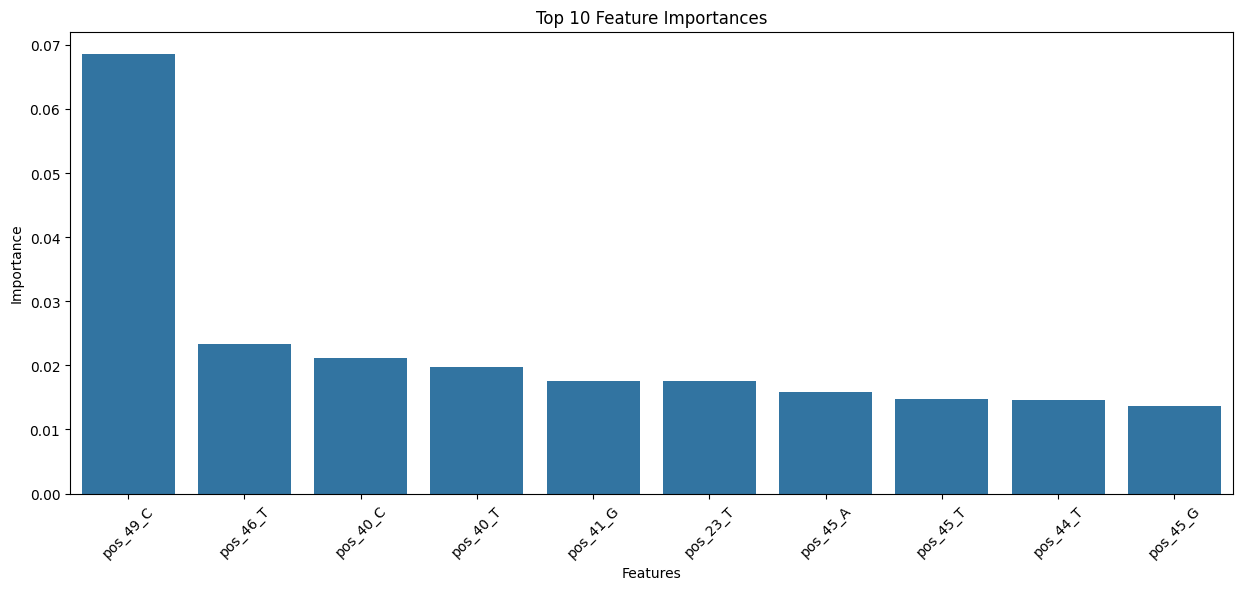

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_importances = df_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(15, 6))
sns.barplot(x='Position', y='Importance', data=df_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=45) 
plt.show()


## Results

In [27]:
print(f'Best parameters found: {grid_solver.best_params_}')
print(f'Best R2 score found: {grid_solver.best_score_}')

print("----Train----")
y_pred_train = model_result_XGB.predict(X_ML_train)
print("R2 Score:", r2_score(y_ML_train, y_pred_train))
print("Mean Squared Error:", mean_squared_error(y_ML_train, y_pred_train))


print("----Test----")
y_pred_test = model_result_XGB.predict(X_ML_test)
print("R2 Score:", r2_score(y_ML_test, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y_ML_test, y_pred_test))

Best parameters found: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best R2 score found: 0.5219227193626069
----Train----
R2 Score: 0.7408702279049411
Mean Squared Error: 0.009963812208276347
----Test----
R2 Score: 0.5482555149262451
Mean Squared Error: 0.020112415714485257


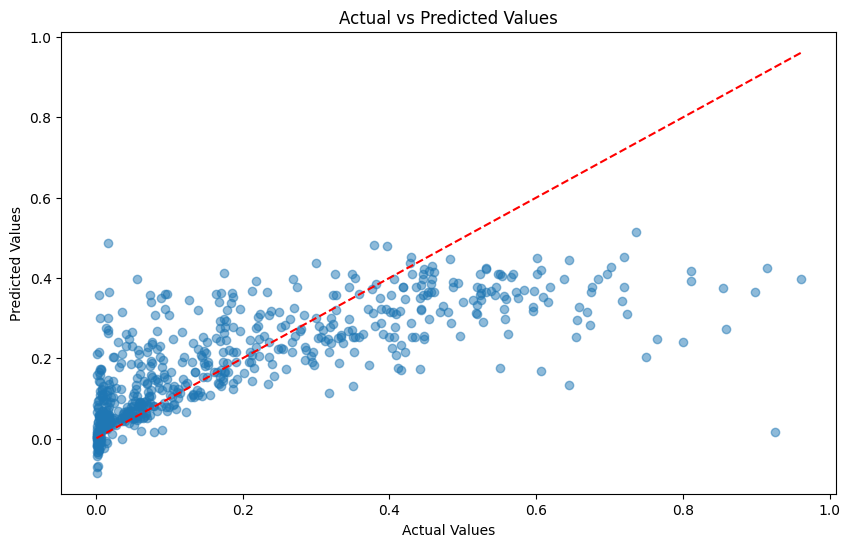

In [29]:
y_pred_test = model_result_XGB.predict(X_ML_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_ML_test, y_pred_test, alpha=0.5)
plt.plot([min(y_ML_test), max(y_ML_test)], [min(y_ML_test), max(y_ML_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Neural Networks

## Multilayer perceptron

In [30]:
model = models.Sequential()

# First layer
model.add(layers.Dense(128, activation='relu', input_shape=(X_ML_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Second layer
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Output
model.add(layers.Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()
history = model.fit(X_ML_train, y_ML_train, epochs=200, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38016     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [31]:
y_pred_train = model.predict(X_ML_train)
y_pred_test = model.predict(X_ML_test)

print("----TRAIN----")
print("R2 Score:", r2_score(y_ML_train, y_pred_train))
print("Mean Squared Error:", mean_squared_error(y_ML_train, y_pred_train))

print("----TEST----")
print("R2 Score:", r2_score(y_ML_test, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y_ML_test, y_pred_test))

20/20 [==============================] - 0s 2ms/step
----TRAIN----
R2 Score: 0.6533953728191324
Mean Squared Error: 0.01332731236487531
----TEST----
R2 Score: 0.53150668625509
Mean Squared Error: 0.020858101419779396


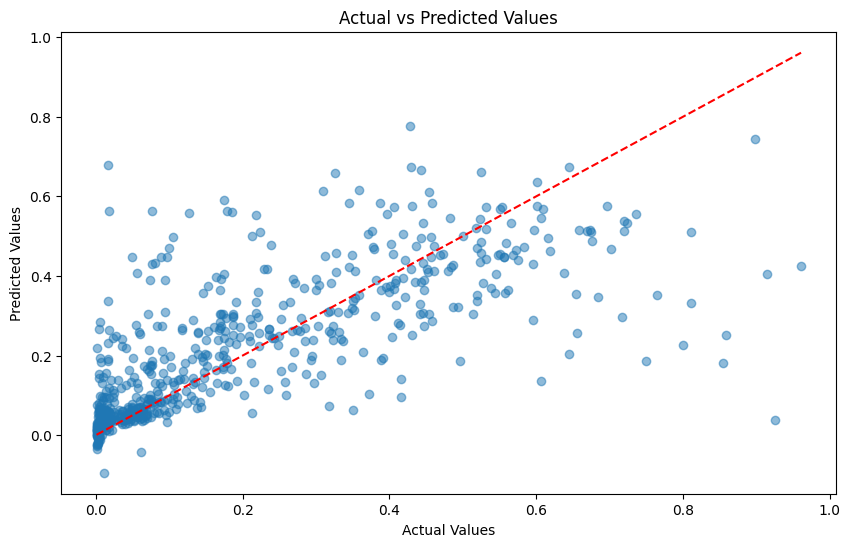

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_ML_test, y_pred_test, alpha=0.5)
plt.plot([min(y_ML_test), max(y_ML_test)], [min(y_ML_test), max(y_ML_test)], 'r--')  # Línea de identidad
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Convulational Neural Network Models

In [33]:
def one_hot_encode_dna(sequences):
    # dictionary for coding
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0] 
    }
    
    # obtain length of sequences and number of sequences
    seq_length = len(sequences[0])
    num_sequences = len(sequences)
    
    # empty matrix for encoded sequences
    one_hot_encoded = np.zeros((num_sequences, seq_length, 4), dtype=np.int8)
    
    # fill matrix with encoded values
    for i, seq in enumerate(sequences):
        for j, nucleotide in enumerate(seq):
            one_hot_encoded[i, j, :] = mapping.get(nucleotide, [0, 0, 0, 0])
    
    return one_hot_encoded

In [34]:
X_cnn_train = list(df_train["Promoter sequence"].str.upper())
X_cnn_train = one_hot_encode_dna(X_cnn_train)

X_cnn_test = list(df_test["Promoter sequence"].str.upper())
X_cnn_test = one_hot_encode_dna(X_cnn_test)

In [35]:
y_cnn_train = df_train["Expression scaled"]
y_cnn_test = df_test["Expression scaled"]

In [36]:
y_cnn_train = np.array(y_cnn_train).astype(np.float32).reshape(-1, 1)
y_cnn_test = np.array(y_cnn_test).astype(np.float32).reshape(-1, 1)

### Sequential model

In [37]:
model = Sequential([
    # First layer
    Conv1D(filters=128, kernel_size=12, activation='relu', padding='same', input_shape=(X_cnn_train.shape[1], X_cnn_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    # Seocnd layer
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    # flatten for the dense layer
    Flatten(),
    
    # dense layer
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    
    # output
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()
model.fit(X_cnn_train, y_cnn_train, epochs=100, batch_size=30, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 74, 128)           6272      
                                                                 
 batch_normalization_2 (Batc  (None, 74, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 37, 128)          0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 37, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 256)           98560     
                                                                 
 batch_normalization_3 (Batc  (None, 37, 256)         

In [38]:
y_pred_train = model.predict(X_cnn_train)
y_pred_test = model.predict(X_cnn_test)

print("----Train----")
print("R2 Score:", r2_score(y_cnn_train, y_pred_train))
print("Mean Squared Error:", mean_squared_error(y_cnn_train, y_pred_train))

print("----Test----")
print("R2 Score:", r2_score(y_cnn_test, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y_cnn_test, y_pred_test))

20/20 [==============================] - 0s 9ms/step
----Train----
R2 Score: 0.2590198516845703
Mean Squared Error: 0.028491467
----Test----
R2 Score: 0.2681012749671936
Mean Squared Error: 0.03258535


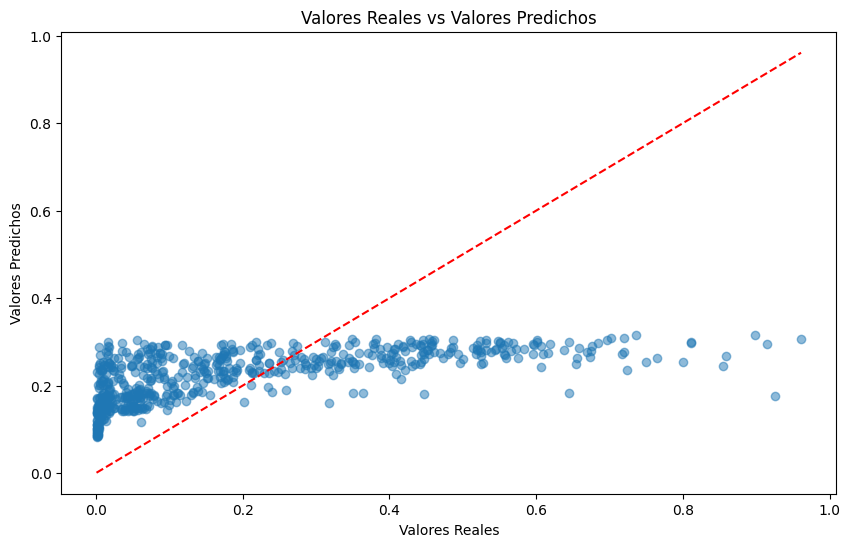

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(y_cnn_test, y_pred_test, alpha=0.5)
plt.plot([min(y_cnn_test), max(y_cnn_test)], [min(y_cnn_test), max(y_cnn_test)], 'r--')  # Línea de identidad
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')
plt.show()

### Inception model

In [40]:
inputs = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2]))

# first tower for transcription factors detection
tower_1 = Conv1D(filters=40, kernel_size=18, activation='relu', padding='same')(inputs)
tower_1 = BatchNormalization()(tower_1)
tower_1 = MaxPooling1D(pool_size=2, strides=2)(tower_1)
tower_1 = Dropout(0.7)(tower_1)

# second tower for -35 and -10 boxes detection
tower_2 = Conv1D(filters=40, kernel_size=6, activation='relu', padding='same')(inputs)
tower_2 = BatchNormalization()(tower_2)
tower_2 = MaxPooling1D(pool_size=2, strides=2)(tower_2)
tower_2 = Dropout(0.7)(tower_2)

# concatenate towers
together = Concatenate(axis=-1)([tower_1, tower_2])

# additional layers
x = MaxPooling1D(pool_size=2, strides=2)(together)
x = Dropout(0.7)(x)

# flatten before dense layer
x = Flatten()(x)

# dense layer
x = Dense(70, activation='relu')(x)

# output
x = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()
model.fit(X_cnn_train, y_cnn_train, epochs=100, batch_size=32, validation_split=0.3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74, 4)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 74, 40)       2920        ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 74, 40)       1000        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 74, 40)      160         ['conv1d_2[0][0]']               
 rmalization)                                                                                 

In [41]:
y_pred_train = model.predict(X_cnn_train)
y_pred_test = model.predict(X_cnn_test)

print("----Train----")
print("R2 Score:", r2_score(y_cnn_train, y_pred_train))
print("Mean Squared Error:", mean_squared_error(y_cnn_train, y_pred_train))

print("----Test----")
print("R2 Score:", r2_score(y_cnn_test, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y_cnn_test, y_pred_test))

20/20 [==============================] - 0s 3ms/step
----Train----
R2 Score: 0.30391114950180054
Mean Squared Error: 0.02676535
----Test----
R2 Score: 0.2645445466041565
Mean Squared Error: 0.032743704


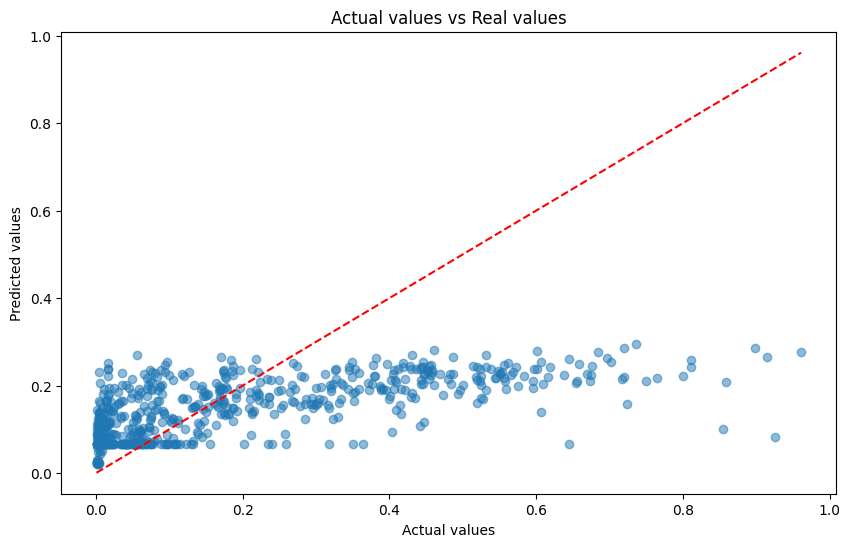

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_cnn_test, y_pred_test, alpha=0.5)
plt.plot([min(y_cnn_test), max(y_cnn_test)], [min(y_cnn_test), max(y_cnn_test)], 'r--')  # Línea de identidad
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual values vs Real values')
plt.show()

### Inception Regularizers

In [45]:
inputs = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2]))

# firs tower for transcription factors detection
tower_1 = Conv1D(filters=30, kernel_size=8, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_1 = MaxPooling1D(pool_size=2)(tower_1)
tower_1 = Dropout(0.7)(tower_1)

# second tower for -35 and -10 boxes detection
tower_2 = Conv1D(filters=30, kernel_size=6, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_2 = MaxPooling1D(pool_size=2)(tower_2)
tower_2 = Dropout(0.7)(tower_2)

# third tower for whole promoters detection
tower_3 = Conv1D(filters=20, kernel_size=30, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_3 = MaxPooling1D(pool_size=2)(tower_3)
tower_3 = Dropout(0.4)(tower_3)

# concatenate towers
together = Concatenate(axis=-1)([tower_1, tower_2, tower_3])

# additional layers
x = MaxPooling1D(pool_size=5)(together)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)


model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()
model.fit(X_cnn_train, y_cnn_train, epochs=100, batch_size=30, validation_split=0.2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 74, 4)]      0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 74, 30)       990         ['input_3[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 74, 30)       750         ['input_3[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 74, 20)       2420        ['input_3[0][0]']                
                                                                                            

In [46]:
y_pred_train = model.predict(X_cnn_train)
y_pred_test = model.predict(X_cnn_test)

print("----Train----")
print("R2 Score:", r2_score(y_cnn_train, y_pred_train))
print("Mean Squared Error:", mean_squared_error(y_cnn_train, y_pred_train))

print("----Test----")
print("R2 Score:", r2_score(y_cnn_test, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y_cnn_test, y_pred_test))

20/20 [==============================] - 0s 3ms/step
----Train----
R2 Score: 0.08950793743133545
Mean Squared Error: 0.035009377
----Test----
R2 Score: 0.07120752334594727
Mean Squared Error: 0.04135139


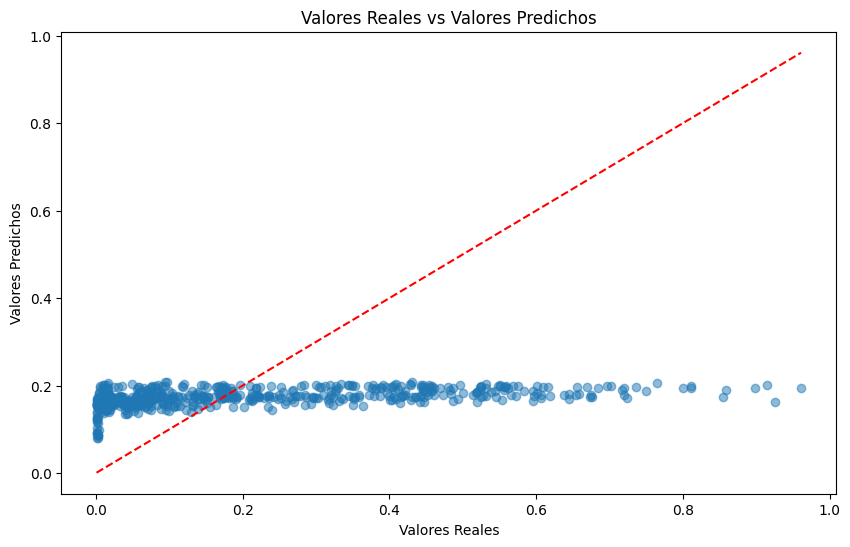

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_cnn_test, y_pred_test, alpha=0.5)
plt.plot([min(y_cnn_test), max(y_cnn_test)], [min(y_cnn_test), max(y_cnn_test)], 'r--')  # Línea de identidad
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')
plt.show()